In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import missingno as msno # 결측치를 확인할 수 있는 라이브러리
import os
import sys

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 컬럼 표시 제한
# pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

# 1. 상황인식

1.배경

안녕하세요 여러분! 구내식당 식수 인원 예측 AI 경진대회에 오신 것을 환영합니다.

지금까지는 단순한 시계열 추세와 담당자의 직관적 경험에 의존하여한국토지주택공사 구내식당 식수 인원을 예측하였으나,

빅데이터 분석으로 얻어지는 보다 정확도 높은 예측을 통해 잔반 발생량을 획기적으로 줄이고자 합니다.

 
2.목적

구내식당의 요일별 점심, 저녁식사를 먹는 인원을 예측

# 2. 데이터 분석

In [2]:
train_df = pd.read_csv('restaurant/train.csv')
train_df.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


In [3]:
test_df = pd.read_csv('restaurant/test.csv')
test_df.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [4]:
train_df['일자'] = train_df['일자'].str.replace('-', '')
train_df.insert(0, 'date', train_df['일자'].str[2:8])
train_df.columns=['date','일자','요일','정원','휴가자','출장자','시간외근무','재택근무','조식','중식','석식','중식계','석식계']
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


In [5]:
train_df['재택근무'].unique()

array([  0.,   5.,   7.,   3.,   1.,  14.,  12.,  19.,  15.,  16.,  20.,
        23.,  17.,  21.,  25., 135., 285., 303., 288., 260., 488., 533.,
       420., 395., 340., 477., 490., 479., 417., 447., 485., 389., 471.,
       450., 443., 437., 387., 418., 410., 396., 189., 291., 246., 245.,
       250., 236., 212., 201., 237., 258., 218., 206., 229., 200., 235.,
       202., 215., 213., 191., 208., 176., 177., 172., 175., 153., 152.,
       157., 158., 159., 148., 143., 183., 166., 140., 129., 149., 134.,
       115., 120., 150., 130., 125., 109., 142.,  95., 102., 111., 112.,
       116., 105., 126., 249., 363., 316., 297., 464., 527., 522., 511.,
       462., 439., 441., 424., 430., 376., 368., 422., 361., 310., 354.,
       342., 345., 314., 265., 292., 279., 221., 188., 171., 180., 144.,
       160., 162., 136., 138., 137., 107., 132., 123., 119., 131., 124.,
       128., 110., 147., 261., 357., 391., 301., 408., 398., 339., 377.,
       419., 337., 336., 400., 359., 334., 307., 33

In [6]:
train_df['중식계'].unique()

array([1039.,  867., 1017.,  978.,  925., 1045.,  909., 1268., 1014.,
        916.,  910.,  763., 1298.,  899., 1022.,  917.,  766.,  869.,
       1127., 1000.,  837., 1326., 1026.,  901.,  847.,  728., 1286.,
        958.,  998.,  832.,  757., 1030.,  963.,  876.,  861., 1193.,
        892., 1033.,  781.,  661., 1237.,  840.,  853.,  764., 1225.,
        771.,  969.,  579., 1120.,  980.,  849.,  940.,  698., 1227.,
        795., 1028.,  811.,  652., 1242.,  964.,  723., 1216., 1008.,
        915.,  753.,  761., 1180.,  856.,  898.,  653., 1160., 1107.,
        938.,  783.,  660., 1231.,  921.,  850.,  721., 1244.,  931.,
        829.,  697., 1243.,  973.,  984.,  800.,  694., 1146., 1091.,
        877.,  805., 1142.,  820.,  886.,  879., 1292.,  952.,  939.,
        857.,  863., 1115.,  919.,  866., 1158.,  888.,  844.,  733.,
       1086.,  927.,  872.,  816.,  671., 1055.,  802.,  641., 1038.,
        874.,  842.,  845.,  708., 1023.,  924.,  943.,  754., 1266.,
       1145.,  941.,

In [7]:
train_df['석식계'].unique()

array([331., 560., 573., 525., 330., 550., 598., 672., 523., 588., 489.,
       597., 645., 610., 514., 531., 585., 344., 631., 473., 673., 625.,
       609., 591., 586., 545., 548., 521., 605., 544., 507., 637., 465.,
       463., 526., 614., 555., 492., 524., 542., 536., 500., 562., 582.,
       449., 504., 557., 528., 568., 490., 508., 551., 515., 636., 519.,
       423., 532., 517., 594., 633., 456., 529., 487., 613., 454., 520.,
       493., 535., 483., 629., 506., 509., 590., 593., 484., 467., 475.,
       446., 513., 494., 534., 630., 503., 596., 424., 443., 501., 584.,
       434., 472., 510., 363., 448., 480., 470., 451., 530., 410., 561.,
       574., 729., 563., 498., 468., 460., 554., 485., 238., 662., 627.,
       603., 533., 710., 622., 539., 902., 905., 352., 546., 522., 527.,
       667., 564., 442., 600., 559., 540., 578., 553., 497., 512., 499.,
       426., 418., 388., 616., 580., 482., 392., 623., 587.,   0., 571.,
       416., 441., 518., 461., 213., 398., 328., 31

In [8]:
train_df['재택근무'] = train_df['재택근무'].astype(int)
train_df['중식계'] = train_df['중식계'].astype(int)
train_df['석식계'] = train_df['석식계'].astype(int)
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식,중식계,석식계
0,160201,20160201,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1205 non-null   object
 1   일자      1205 non-null   object
 2   요일      1205 non-null   object
 3   정원      1205 non-null   int64 
 4   휴가자     1205 non-null   int64 
 5   출장자     1205 non-null   int64 
 6   시간외근무   1205 non-null   int64 
 7   재택근무    1205 non-null   int64 
 8   조식      1205 non-null   object
 9   중식      1205 non-null   object
 10  석식      1205 non-null   object
 11  중식계     1205 non-null   int64 
 12  석식계     1205 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 122.5+ KB


In [10]:
test_df['일자'] = test_df['일자'].str.replace('-', '')
test_df.insert(0, 'date', train_df['일자'].str[2:8])
test_df.columns=['date','일자','요일','정원','휴가자','출장자','시간외근무','재택근무','조식','중식','석식']
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식
0,160201,20210127,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [11]:
test_df['재택근무'] = train_df['재택근무'].astype(int)
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식
0,160201,20210127,수,2983,88,182,5,0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    50 non-null     object
 1   일자      50 non-null     object
 2   요일      50 non-null     object
 3   정원      50 non-null     int64 
 4   휴가자     50 non-null     int64 
 5   출장자     50 non-null     int64 
 6   시간외근무   50 non-null     int64 
 7   재택근무    50 non-null     int64 
 8   조식      50 non-null     object
 9   중식      50 non-null     object
 10  석식      50 non-null     object
dtypes: int64(5), object(6)
memory usage: 4.4+ KB


In [13]:
# sample_submission = pd.read_csv('restaurant/sample_submission.csv')
# sample_submission

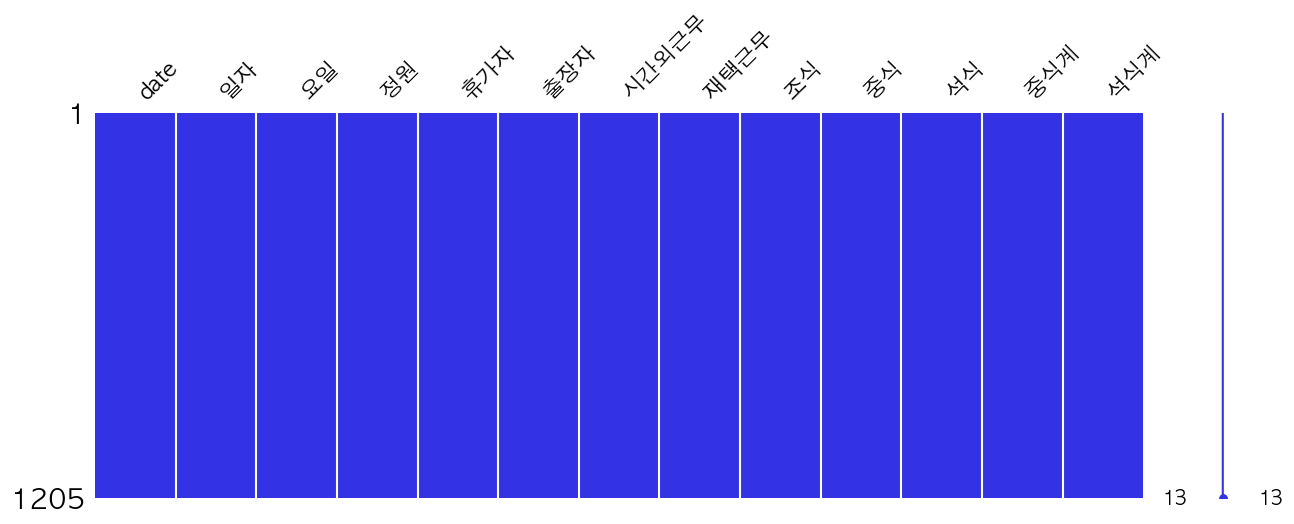

In [17]:
msno.matrix(df=train_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5));

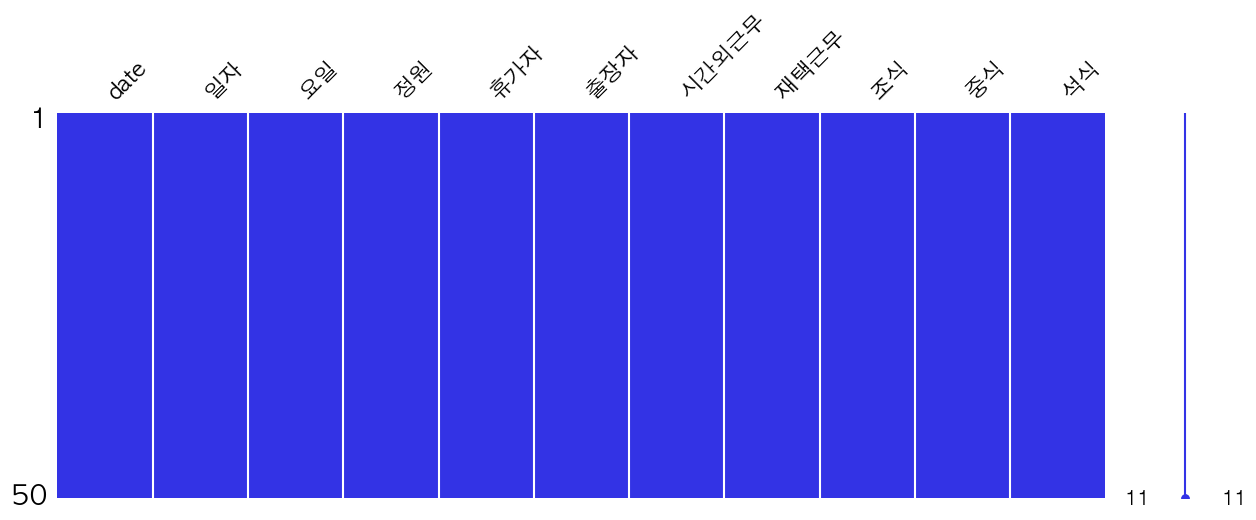

In [18]:
msno.matrix(df=test_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5));

In [24]:
train_df['조식'].head()

0    모닝롤/찐빵  우유/두유/주스 계란후라이  호두죽/쌀밥 (쌀:국내산) 된장찌개  쥐...
1    모닝롤/단호박샌드  우유/두유/주스 계란후라이  팥죽/쌀밥 (쌀:국내산) 호박젓국찌...
2    모닝롤/베이글  우유/두유/주스 계란후라이  표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...
3    모닝롤/토마토샌드  우유/두유/주스 계란후라이  닭죽/쌀밥 (쌀,닭:국내산) 근대국...
4    모닝롤/와플  우유/두유/주스 계란후라이  쇠고기죽/쌀밥 (쌀:국내산) 재첩국  방...
Name: 조식, dtype: object

In [25]:
import re

def split_text(stringData):
    pattern1 = r'\([^)]*\)'
    
    text = re.sub(pattern=pattern1, repl='', string=stringData)
    
    text = text.replace('/',' ')
    text = text.replace('  ',' ')
    text = text.replace('*',' ')
    if text[-1] == ' ':
        text = text[:-1]
    return text

In [29]:
train_df['조식_split'] = train_df['조식'].apply(split_text)
train_df['중식_split'] = train_df['중식'].apply(split_text)
train_df['석식_split'] = train_df['석식'].apply(split_text)

print(train_df['조식_split'][0])
print(train_df['중식_split'][0])
print(train_df['석식_split'][0])

모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치
쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치
쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치


In [31]:
train_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,조식,중식,석식,중식계,석식계,조식메뉴_split,중식메뉴_split,석식메뉴_split,조식_split,중식_split,석식_split
0,160201,20160201,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치


In [44]:
morning_menu_list = []
lunch_menu_list = []
dinner_menu_list = []

for i in train_df['조식_split']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        morning_menu_list.append(j)
        
for i in train_df['중식_split']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        lunch_menu_list.append(j)
        
for i in train_df['석식_split']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        dinner_menu_list.append(j)
        
morning_menu_list

['모닝롤',
 '찐빵',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '호두죽',
 '쌀밥',
 '된장찌개',
 '쥐어채무침',
 '포기김치',
 '모닝롤',
 '단호박샌드',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '팥죽',
 '쌀밥',
 '호박젓국찌개',
 '시래기조림',
 '포기김치',
 '모닝롤',
 '베이글',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '표고버섯죽',
 '쌀밥',
 '콩나물국',
 '느타리호박볶음',
 '포기김치',
 '모닝롤',
 '토마토샌드',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '닭죽',
 '쌀밥',
 '근대국',
 '멸치볶음',
 '포기김치',
 '모닝롤',
 '와플',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '쇠고기죽',
 '쌀밥',
 '재첩국',
 '방풍나물',
 '포기김치',
 '팬케익',
 '찐빵',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '견과류죽',
 '쌀밥',
 '감자찌개',
 '명엽채무침',
 '포기김치',
 '모닝롤',
 '야채샌드',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '고구마죽',
 '쌀밥',
 '봄동된장국',
 '숙주나물',
 '포기김치',
 '모닝롤',
 '치즈프레즐',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '잣죽',
 '쌀밥',
 '민물새우찌개',
 '콩조림',
 '포기김치',
 '모닝롤',
 '마늘빵',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '단호박죽',
 '쌀밥',
 '어묵국',
 '김구이',
 '포기김치',
 '모닝롤',
 '참치샌드',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '흑임자죽',
 '쌀밥',
 '북어계란국',
 '무생채',
 '포기김치',
 '모닝롤',
 '인절미토스트',
 '우유',
 '두유',
 '주스',
 '계란후라이',
 '계란후라이',
 '',
 '선지해장국',
 '톳두부무침',
 '포기김치',
 

In [37]:
type(morning_menu_list)

list

In [38]:
list(set(morning_menu_list))

['',
 '깻잎순나물볶음',
 '단호박샌드',
 '닭개장',
 '우엉어묵볶음',
 '두부양념찜',
 '맑은조개탕',
 '순두부된장국',
 '계란후라이',
 '누룽지',
 '양념김',
 '그린샐러드',
 '버섯매운탕',
 '근대국',
 '조랭이떡미역국',
 '우엉땅콩조림',
 '방울양배추베이컨볶음',
 '모닝샌드',
 '밤죽',
 '야채햄샌드',
 '도토리묵무침',
 '김치순두부찌개',
 '유채나물무침',
 '돈육마늘장조림',
 '소라살죽',
 '김자반',
 '모둠장조림',
 '비트무생채',
 '통아몬드멸치볶음',
 '소시지감자볶음',
 '된장찌개',
 '가지볶음',
 '자반김',
 '김치국',
 '치커리무침',
 '사과파이',
 '오징어국',
 '마늘쫑맛살볶음',
 '호박잎찌개',
 '핫케이크',
 '구운계란',
 '새알팥죽',
 '섭산적채소조림',
 '오리엔탈D',
 '건새우무채국',
 '호박채나물',
 '쇠고기해장국',
 '생깻잎지',
 '버섯죽',
 '카레감자볶음',
 '샌드위치',
 '베이비샐러드',
 '토마토샌드위치',
 '오곡죽',
 '참치모닝샌드',
 '크렌베리멸치볶음',
 '무채국',
 '감자고추장찌개',
 '야채샌드',
 '매운어묵국',
 '배추국',
 '통마늘너비아니조림',
 '건새우무국',
 '유부장국',
 '감자채햄볶음',
 '참나물',
 '스틱치즈케익',
 '칠리소스두부브로컬리볶음',
 '깍두기',
 '콩나물간장조림',
 '느타리버섯국',
 '길거리토스트',
 '바지락죽',
 '새알만두국',
 '봄동겉절이',
 '고사리들깨볶음',
 '우엉간장조림',
 '매운감자국',
 '콩나물국',
 '치커리유자무침',
 '핫도그',
 '불고기브리또',
 '콩나물된장국',
 '구구마순나물',
 '버섯맑은국',
 '프렌치토스트',
 '햄에그치즈토스트',
 '피바지락배추국',
 '아귀채무침',
 '누룽지탕죽',
 '메론빵',
 '감자샌드',
 '시래기나물',
 '순두부찌개',
 '명엽채고추장볶음',
 '야채소시지전',
 '배추된장국',
 '베이컨숙주볶음'

In [40]:
len(morning_menu_list)

12302

In [41]:
len(list(set(morning_menu_list)))

787

In [45]:
lunch_menu_list

['쌀밥',
 '잡곡밥',
 '오징어찌개',
 '쇠불고기',
 '계란찜',
 '청포묵무침',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '김치찌개',
 '가자미튀김',
 '모둠소세지구이',
 '마늘쫑무침',
 '요구르트',
 '배추겉절이',
 '카레덮밥',
 '팽이장국',
 '치킨핑거',
 '쫄면야채무침',
 '견과류조림',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '쇠고기무국',
 '주꾸미볶음',
 '부추전',
 '시금치나물',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '떡국',
 '돈육씨앗강정',
 '우엉잡채',
 '청경채무침',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '시래기국',
 '훈제오리구이',
 '도토리묵무침',
 '쌈무',
 '양파절임',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '꽃게탕',
 '돈육굴소스볶음',
 '옥수수전',
 '유채나물',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '시금치국',
 '닭감자조림',
 '연두부',
 '양념장',
 '콩나물무침',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '쇠고기무국',
 '탕수어',
 '오징어숙회무침',
 '취나물',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '냉이된장국',
 '쇠고기장조림',
 '통도라지구이',
 '치커리무침',
 '요구르트',
 '포기김치',
 '낙지비빔밥',
 '유부장국',
 '고구마치즈구이',
 '해초무침',
 '요구르트',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '대구찌개',
 '마늘간장치킨',
 '새송이버섯볶음',
 '돌나물무침',
 '치킨무',
 '요구르트',
 '포기김치',
 '쌀밥',
 '오곡밥',
 '쇠고기느타리국',
 '갈치구이',
 '호박꼬지&고사리&무나물',
 '파래김',
 '양념장',
 '부럼',
 '요구르트',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '콩나물국',
 '돈육간

In [46]:
dinner_menu_list

['쌀밥',
 '잡곡밥',
 '육개장',
 '자반고등어구이',
 '두부조림',
 '건파래무침',
 '포기김치',
 '콩나물밥',
 '양념장',
 '어묵국',
 '유산슬',
 '아삭고추무침',
 '바나나',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '청국장찌개',
 '황태양념구이',
 '고기전',
 '새송이버섯볶음',
 '포기김치',
 '미니김밥',
 '겨자장',
 '우동',
 '멕시칸샐러드',
 '군고구마',
 '무피클',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '차돌박이찌개',
 '닭갈비',
 '감자소세지볶음',
 '콩나물무침',
 '포기김치',
 '참치회덮밥',
 '맑은국',
 '군만두',
 '과일샐러드',
 '락교',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '김치콩나물국',
 '미니함박',
 '어묵볶음',
 '물파래무침',
 '깍두기',
 '쌀밥',
 '잡곡밥',
 '홍합미역국',
 '등갈비김치찜',
 '임연수구이',
 '브로컬리초장',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '된장찌개',
 '쇠불고기',
 '해파리겨자채',
 '봄동무침',
 '포기김치',
 '볶음밥',
 '자장소스',
 '맑은국',
 '새우또띠아',
 '쨔샤이무침',
 '요플레',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '순두부찌개',
 '명태조림',
 '감자채볶음',
 '쌈만두',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '설렁탕',
 '김치전',
 '야채스틱',
 '바나나',
 '석박지',
 '쌀밥',
 '잡곡밥',
 '옹심이만두국',
 '떡갈비조림',
 '청포묵무침',
 '부추오이생채',
 '포기김치',
 '쌀밥',
 '잡곡밥',
 '콩비지찌개',
 '해물까스&타르타르소스',
 '볶음쌀국수',
 '미역레몬초무침',
 '통배추겉절이',
 '쌀밥',
 '잡곡밥',
 '열무된장국',
 '매운돼지갈비찜',
 '멸치호두볶음',
 '숙주나물',
 '포기김치',
 '김밥',
 '잔치국수',
 '교자만두',
 '멕시칸샐러드',
 '무피클',
 '포기김치',
 '쌀밥'

In [ ]:
# 오늘 시간 남아서 조금 더 해볼게요 :) 